In [ ]:
# Importations
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, LSTM, Reshape, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator

import seaborn as sns

In [41]:
class Graphes:

    @staticmethod
    def accuracy_loss_graphe(historique):
        # Affichage accuracy - loss
        fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
        axs = axs.flatten()
        axs[0].plot(historique.history["accuracy"], label='Accuracy Train')
        axs[0].plot(historique.history["val_accuracy"], label='Accuracy Test')
        axs[0].set_title(f"Evolution de l'accuracy")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()

        axs[1].plot(historique.history["loss"], label='Loss Train')
        axs[1].plot(historique.history["val_loss"], label='Loss Test')
        axs[1].set_title(f"Evolution de la perte")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        plt.show()

In [42]:
class ImageGenerator:

    @staticmethod
    def create_imperfect_image(image, image_size=(56, 56)):

        new_image = np.ones((*image_size, image.shape[2]), dtype=np.uint8)

        max_offset = image_size[0] - image.shape[0]
        random_x = random.randint(0, max_offset)
        random_y = random.randint(0, max_offset)

        new_image[random_x:random_x+image.shape[0], random_y:random_y+image.shape[1], :] = image
        return new_image

In [43]:
def generation_propre(X, y, nb=10000):
    datagen = ImageDataGenerator(
        rotation_range=60,
        width_shift_range=0.3,   # Décalage horizontal
        height_shift_range=0.15,  # Décalage vertical
        zoom_range=0.2,          # Zoom
    )

    new_images_generator = datagen.flow(X, batch_size=1, shuffle=False)

    X_new = X.tolist()
    y_new = y.tolist()
    for i in range(nb):
        img = next(new_images_generator)[0]
        X_new.append(img.tolist())
        y_new.append(y[i].tolist())

        if i < 1:
          plt.figure()
          plt.imshow(img, cmap="grey")
          plt.axis('off')
          plt.show()
    return np.array(X_new), np.array(y_new)


In [44]:
# Création image 56 x 56 avec chiffre positioné aléatoirement
# L'image est ensuite redimensionnée -> 28 x 28

def generation_2(X, y, nb=10000):
    new_images = X.tolist()
    new_images_label = y.tolist()

    for i in range(nb):
        imperfect_image = ImageGenerator.create_imperfect_image(X[i])

        # imperfect_image = tf.image.resize(imperfect_image, (28, 28))
        imperfect_image = tf.expand_dims(imperfect_image, axis=0)
        imperfect_image = tf.nn.max_pool2d(imperfect_image, ksize=2, strides=2, padding="VALID")

        imperfect_image = imperfect_image.numpy().reshape(28, 28, 1)


        new_images.append(imperfect_image.tolist())
        new_images_label.append(y[i].tolist())

        if i < 1:
          plt.figure()
          plt.imshow(imperfect_image, cmap="grey")
          plt.axis('off')
          plt.show()

    new_images = np.array(new_images)
    new_images_label = np.array(new_images_label)

    return new_images, new_images_label

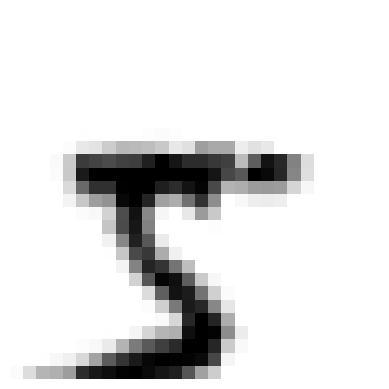

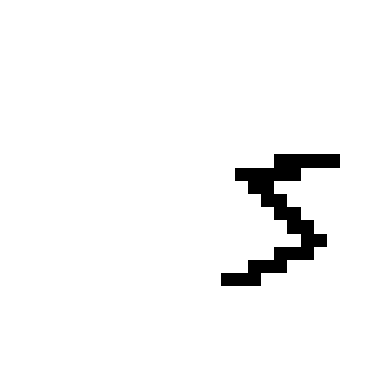

In [45]:
# Charger les données MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalisation
x_train = x_train / 255.0
x_test = x_test / 255.0

# Inversion
x_train = 1 - x_train
x_test = 1 - x_test

x_train, y_train = generation_propre(x_train, y_train, 15000)
x_train, y_train = generation_2(x_train, y_train, 15000)


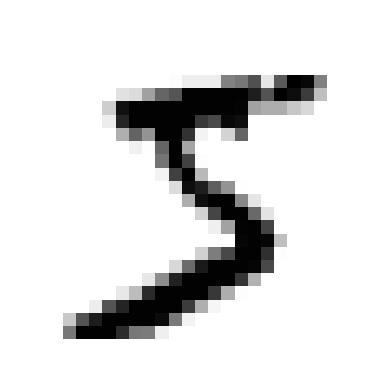

In [46]:
# Apercu dataset
for i in range(1):
    plt.figure()
    plt.imshow(x_train[i], cmap="grey")
    plt.axis('off')
    plt.show()

In [24]:
# Optimisation Bayésienne

def build_model(hp):
    model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(hp.Choice('rate_1', [0.2, 0.3, 0.4])),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(hp.Choice('rate_2', [0.2, 0.3, 0.4])),

      Reshape((-1, 64)),
      Bidirectional(LSTM(hp.Choice('units', [64, 128, 256, 512]), activation='tanh')),
      BatchNormalization(),
      Dropout(hp.Choice('rate_3', [0.2, 0.3, 0.4, 0.5])),

      Dense(10, activation="softmax")
    ])
    optimizer = Adam(hp.Choice('learning_rate', [0.01, 0.001, 0.0001]), weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_tuning',
    project_name='mnist'
)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Meilleures valeurs trouvées :", best_hyperparameters.values)


Trial 10 Complete [00h 04m 16s]
val_accuracy: 0.9912999868392944

Best val_accuracy So Far: 0.9919999837875366
Total elapsed time: 00h 33m 36s
Meilleures valeurs trouvées : {'rate_1': 0.4, 'rate_2': 0.4, 'units': 256, 'rate_3': 0.5, 'learning_rate': 0.001}


In [ ]:
# Optimisation random search

def build_model(learning_rate=0.001, rate_1=0.2, rate_2=0.3, rate_3=0.4, units=64):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2), strides=2),
        Dropout(rate_1),

        Conv2D(64, (3, 3), activation='relu', padding="same"),
        MaxPooling2D((2, 2), strides=2),
        Dropout(rate_2),

        Reshape((-1, 64)),
        Bidirectional(GRU(units, activation='tanh')),
        Dropout(rate_3),

        Dense(10, activation="softmax")
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    return model

class KerasModelWrapper(BaseEstimator):
    def __init__(self, learning_rate=0.001, rate_1=0.2, rate_2=0.3, rate_3=0.4, units=64):
        self.learning_rate = learning_rate
        self.rate_1 = rate_1
        self.rate_2 = rate_2
        self.rate_3 = rate_3
        self.units = units
        self.model = None

    def fit(self, x, y):
        self.model = build_model(
            learning_rate=self.learning_rate,
            rate_1=self.rate_1,
            rate_2=self.rate_2,
            rate_3=self.rate_3,
            units=self.units
        )
        self.model.fit(x, y, epochs=5, batch_size=32)

    def score(self, x, y):
        return self.model.evaluate(x, y, verbose=0)[1]

param_distributions = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'rate_1': [0.2, 0.3, 0.4],
    'rate_2': [0.2, 0.3, 0.4],
    'rate_3': [0.3, 0.4, 0.5],
    'units': [64, 128, 256],
}

# Créer l'objet modèle KerasWrapper
keras_model = KerasModelWrapper()

random_search = RandomizedSearchCV(
    estimator=keras_model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1       # Utilise tous les cœurs disponibles
)
random_search.fit(x_train, y_train)

print("Meilleurs paramètres trouvés :", random_search.best_params_)


In [59]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Dropout(0.4),

    Conv2D(64, (3, 3), activation='relu', padding="same"),
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Dropout(0.4),

    Reshape((-1, 128)),
    Bidirectional(GRU(128, activation='tanh')),
    BatchNormalization(),
    Dropout(0.4),


    Dense(10, activation="softmax")
])
optimizer = Adam(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
# Entrainement
historique = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.6738 - loss: 1.0810 - val_accuracy: 0.9842 - val_loss: 0.0470
Epoch 2/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.9103 - loss: 0.2852 - val_accuracy: 0.9838 - val_loss: 0.0490
Epoch 3/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.9342 - loss: 0.2120 - val_accuracy: 0.9896 - val_loss: 0.0317
Epoch 4/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.9461 - loss: 0.1754 - val_accuracy: 0.9898 - val_loss: 0.0287
Epoch 5/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.9517 - loss: 0.1559 - val_accuracy: 0.9886 - val_loss: 0.0332
Epoch 6/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9556 - loss: 0.1471 - val_accuracy: 0.9924 - val_loss: 0.0244
Epoch 7/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.9588 - loss: 0.1359 - val_accuracy: 0.9914 - val_loss: 0.0282
Epoch 8/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.9608 -

In [65]:
# Sauvegarde

model.save('mon_modele.h5')
from google.colab import files
files.download('mon_modele.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Charger
from tensorflow.keras.models import load_model

model = load_model("model/mon_modele.h5")

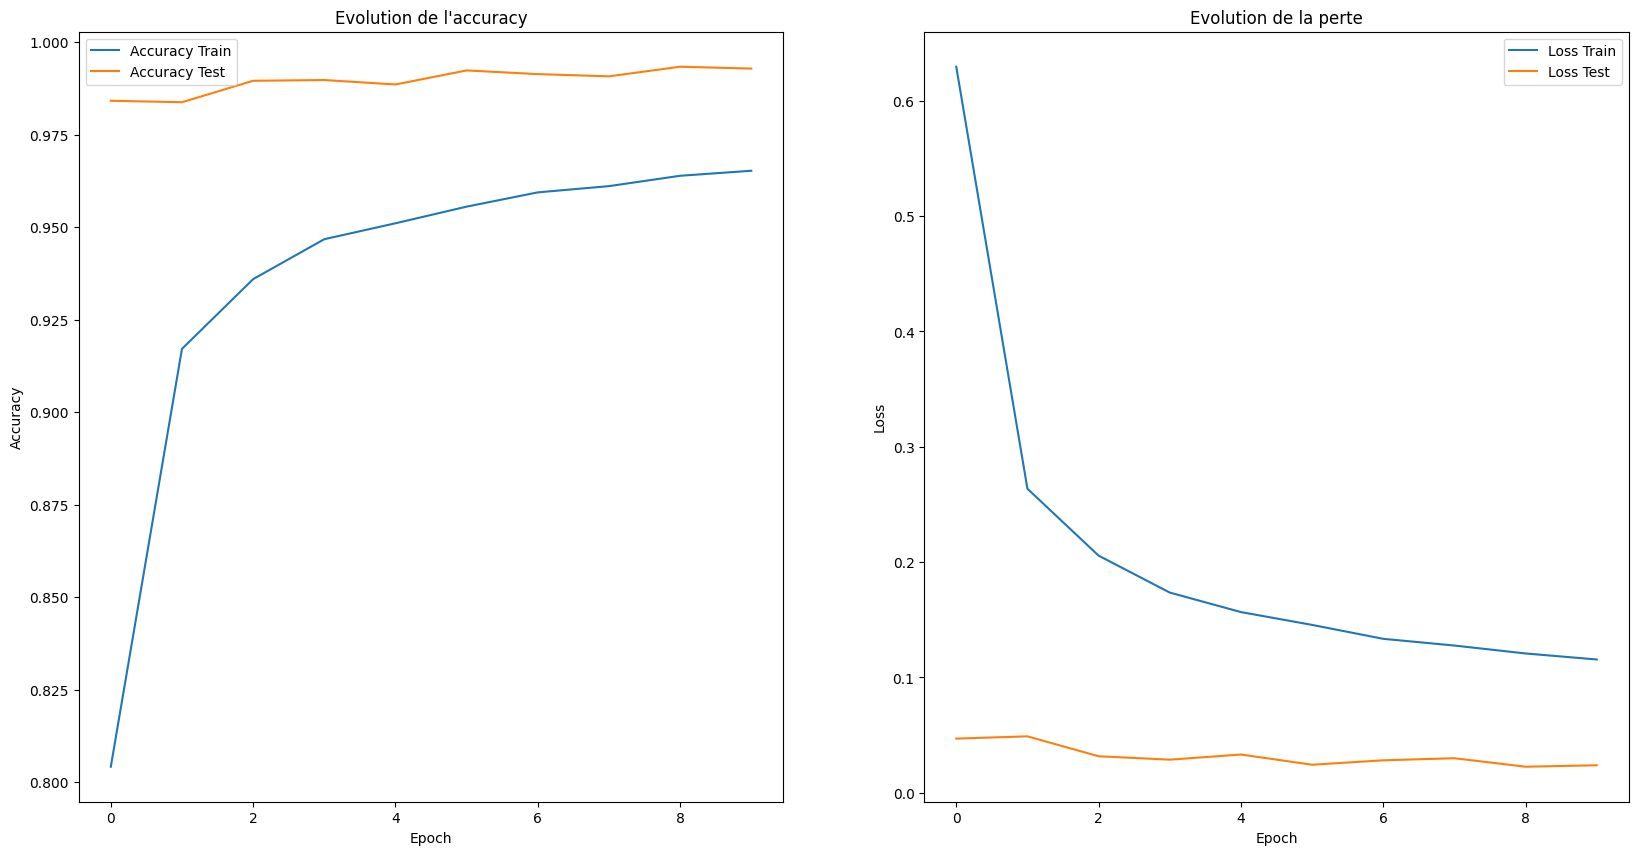

In [61]:
Graphes.accuracy_loss_graphe(historique)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      0.99      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



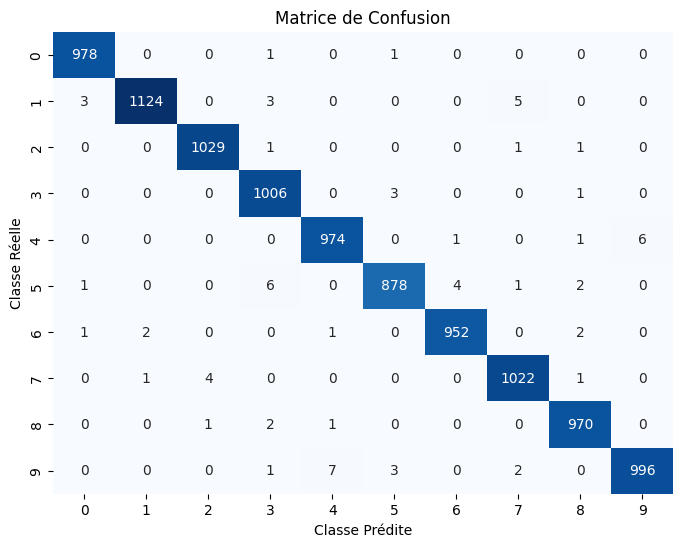

In [62]:
# Stats et matrice de confusion

predictions = np.argmax(model.predict(x_test), axis=1)

print(classification_report(y_test, predictions, target_names=["0","1","2","3","4","5", "6","7", "8", "9"]))

confusion = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_1.png", format="png")
plt.show()


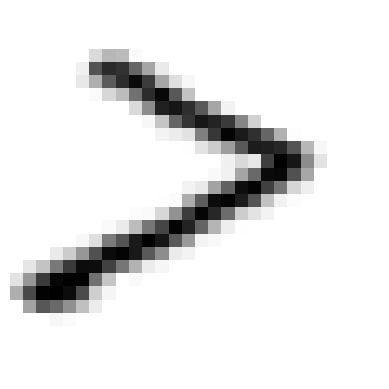

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1960
           1       1.00      0.99      0.99      2270
           2       0.95      0.97      0.96      2064
           3       0.95      0.98      0.97      2020
           4       0.97      0.97      0.97      1964
           5       0.98      0.95      0.97      1784
           6       0.98      0.98      0.98      1916
           7       0.97      0.94      0.96      2056
           8       0.97      0.98      0.97      1948
           9       0.97      0.97      0.97      2018

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



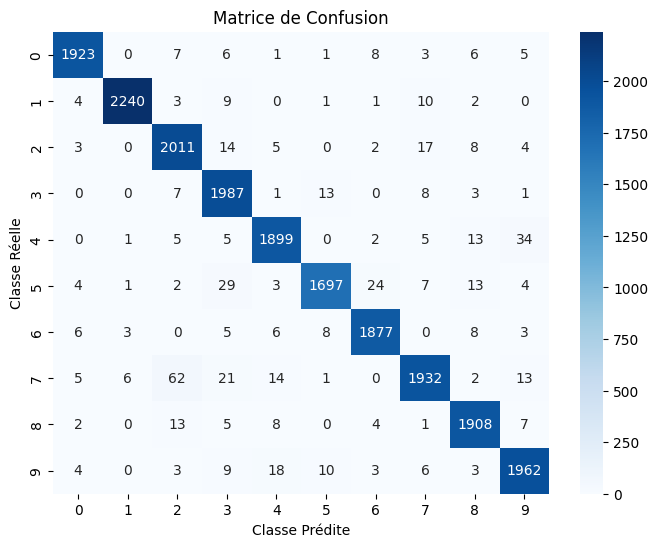

In [63]:

new_images, new_images_label = generation_propre(x_test, y_test)



# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images), axis=1)

print(classification_report(new_images_label, new_pred))

confusion = confusion_matrix(new_images_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()



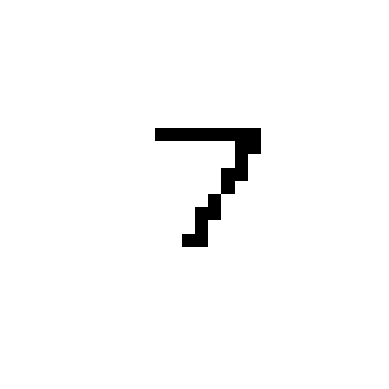

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1960
           1       0.99      0.98      0.99      2270
           2       0.98      0.98      0.98      2064
           3       0.93      0.98      0.96      2020
           4       0.97      0.97      0.97      1964
           5       0.97      0.96      0.97      1784
           6       0.98      0.99      0.98      1916
           7       0.97      0.97      0.97      2056
           8       0.97      0.98      0.97      1948
           9       0.98      0.93      0.95      2018

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



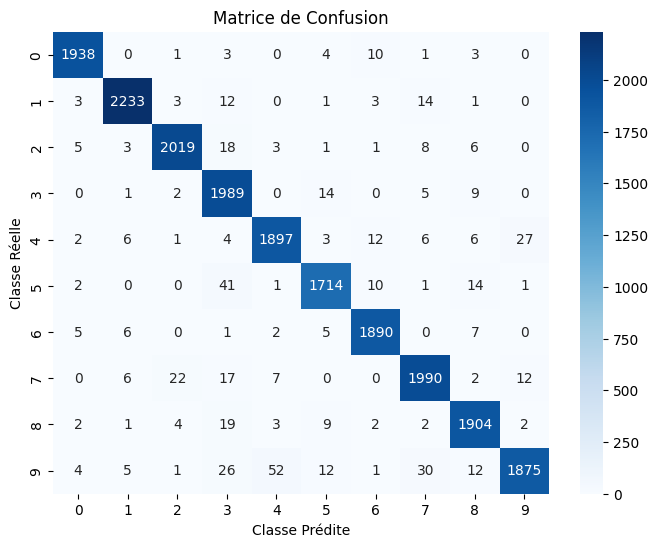

In [64]:

new_images, new_images_label = generation_2(x_test, y_test)



# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images), axis=1)

print(classification_report(new_images_label, new_pred))

confusion = confusion_matrix(new_images_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()

